In [ ]:
%cd /content/drive/MyDrive/VGG_Face

/content/drive/MyDrive/VGG_Face


In [ ]:
#procedure to download kaggle datasets to google drive
import os

os.environ['KAGGLE_USERNAME'] = "lalit871" # username from the json file
os.environ['KAGGLE_KEY'] = "3c73e02f6583673b8cf22e6a965e2de5" # key from the json file

In [ ]:
!mkdir VGG_Face

In [ ]:
%cd VGG_Face

/content/drive/MyDrive/VGG_Face


In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_matconvnet.tar.gz

--2021-02-09 03:04:12--  https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_matconvnet.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1086906808 (1.0G) [application/x-gzip]
Saving to: ‘vgg_face_matconvnet.tar.gz’

vgg_face_matconvnet 100%[===================>]   1.01G  58.2MB/s    in 17s     

2021-02-09 03:04:29 (61.0 MB/s) - ‘vgg_face_matconvnet.tar.gz’ saved [1086906808/1086906808]



In [ ]:
!tar -xf /content/drive/MyDrive/VGG_Face/vgg_face_matconvnet.tar.gz

In [ ]:
import numpy as np
from tensorflow.keras import Model
from google.colab.patches import cv2_imshow
import os
import itertools
import cv2
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from pathlib import Path
import pandas as pd

In [ ]:
data = loadmat('/content/drive/MyDrive/VGG_Face/vgg_face_matconvnet/data/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Oct 13 16:54:01 2015',
 '__version__': '1.0',
 'net': array([[<scipy.io.matlab.mio5_params.mat_struct object at 0x7fe547e38590>]],
       dtype=object)}

In [ ]:
net = data['net'][0][0]

In [ ]:
model_layers = net.layers
model_layers.shape

(1, 39)

In [ ]:
l = model_layers.shape[1]

In [ ]:
for k in range(l):
    try:
        print(f'{model_layers[0][k][0][0].name}----->{model_layers[0][k][0][0].weights[0][0].shape}')
    except:
        print(f'{model_layers[0][k][0][0].name}')

['conv1_1']----->(3, 3, 3, 64)
['relu1_1']
['conv1_2']----->(3, 3, 64, 64)
['relu1_2']
['pool1']
['conv2_1']----->(3, 3, 64, 128)
['relu2_1']
['conv2_2']----->(3, 3, 128, 128)
['relu2_2']
['pool2']
['conv3_1']----->(3, 3, 128, 256)
['relu3_1']
['conv3_2']----->(3, 3, 256, 256)
['relu3_2']
['conv3_3']----->(3, 3, 256, 256)
['relu3_3']
['pool3']
['conv4_1']----->(3, 3, 256, 512)
['relu4_1']
['conv4_2']----->(3, 3, 512, 512)
['relu4_2']
['conv4_3']----->(3, 3, 512, 512)
['relu4_3']
['pool4']
['conv5_1']----->(3, 3, 512, 512)
['relu5_1']
['conv5_2']----->(3, 3, 512, 512)
['relu5_2']
['conv5_3']----->(3, 3, 512, 512)
['relu5_3']
['pool5']
['fc6']----->(7, 7, 512, 4096)
['relu6']
['dropout6']
['fc7']----->(1, 1, 4096, 4096)
['relu7']
['dropout7']
['fc8']----->(1, 1, 4096, 2622)
['softmax']


In [ ]:
model = Sequential()
 
for k in range(l):
    model_layer = model_layers[0][k][0][0].name[0]
    if model_layer.find("conv") == 0 or model_layer.find("fc") == 0:
        weights = model_layers[0][k][0][0].weights
        weight_shape = weights[0][0].shape
        filter_x = weight_shape[0]
        filter_y = weight_shape[1]
        number_of_filters = weight_shape[3]
 
        if model_layer.find("conv") == 0:
            if k == 0:
                model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
            else:
                model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(number_of_filters, (filter_x, filter_y), name= model_layer))
    
    else:
        if model_layer.find("relu") == 0:
            model.add(Activation('relu', name= model_layer))
        elif model_layer.find("dropout") == 0:
            model.add(Dropout(0.5, name= model_layer))
        elif model_layer.find("pool") == 0:
            model.add(MaxPooling2D((2,2), strides=(2,2), name= model_layer))
        elif model_layer.find("softmax") == 0:
            model.add(Activation('softmax', name= model_layer))
        else:
            print("This layer was not processed: ", model_layer)

In [ ]:
base_model_layer_names = [layer.name for layer in model.layers]
num_of_ref_model_layers = model_layers.shape[1]
for i in range(num_of_ref_model_layers):
 ref_model_layer = model_layers[0][i][0][0].name[0]
 if ref_model_layer in base_model_layer_names:
  #we just need to set convolution and fully connected weights
  if ref_model_layer.find("conv") == 0 or ref_model_layer.find("fc") == 0:
   print(i,". ",ref_model_layer)
   base_model_index = base_model_layer_names.index(ref_model_layer)
 
   weights = model_layers[0][i][0][0].weights[0,0]
   bias = model_layers[0][i][0][0].weights[0,1]
 
   model.layers[base_model_index].set_weights([weights, bias[:,0]])


0 .  conv1_1
2 .  conv1_2
5 .  conv2_1
7 .  conv2_2
10 .  conv3_1
12 .  conv3_2
14 .  conv3_3
17 .  conv4_1
19 .  conv4_2
21 .  conv4_3
24 .  conv5_1
26 .  conv5_2
28 .  conv5_3
31 .  fc6
34 .  fc7
37 .  fc8


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
relu1_1 (Activation)         (None, 224, 224, 64)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
relu1_2 (Activation)         (None, 224, 224, 64)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0

**Image Preprocessing**

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

**Euclidean Distance**

In [ ]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

# def findCosineDistance(source_representation, test_representation):
#     a = np.matmul(np.transpose(source_representation), test_representation)
#     b = np.sum(np.multiply(source_representation, source_representation))
#     c = np.sum(np.multiply(test_representation, test_representation))
#     return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

**Finding distance using feature vectors**

In [ ]:
def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image(img1))
    img2_representation = vgg_face_descriptor.predict(preprocess_image(img2))
 
    # cosine_similarity = findCosineDistance(img1_representation[0,:], img2_representation[0,:])
    euclidean_distance = findEuclideanDistance(img1_representation[0,:], img2_representation[0,:])
    return euclidean_distance

In [ ]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output) # face model 

**Creating match and mismatch pairs**

In [ ]:
path = '/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/'

In [ ]:
#Identities
idendities = {
 "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg"
 , "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
 "Scarlett": ["img8.jpg", "img9.jpg"],
 "Jennifer": ["img3.jpg", "img12.jpg"],
 "Mark": ["img13.jpg", "img14.jpg", "img15.jpg"],
 "Jack": ["img16.jpg", "img17.jpg"],
 "Elon": ["img18.jpg", "img19.jpg"],
 "Jeff": ["img20.jpg", "img21.jpg"],
 "Marissa": ["img22.jpg", "img23.jpg"],
 "Sundar": ["img24.jpg", "img25.jpg"]
}

In [ ]:
#Positives
positives = []
for key, values in idendities.items():
 for i in range(0, len(values)-1):
  for j in range(i+1, len(values)):
   positive = []
   positive.append(path+values[i])
   positive.append(path+values[j])
   positives.append(positive)
 
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [ ]:
samples_list = list(idendities.values())
 
#negatives
negatives = []
for i in range(0, len(idendities) - 1):
 for j in range(i+1, len(idendities)):
  cross_product = itertools.product(samples_list[i], samples_list[j])
  cross_product = list(cross_product)
 
  for cross_sample in cross_product:
   negative = []
   negative.append(path+cross_sample[0])
   negative.append(path+cross_sample[1])
   negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [ ]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [ ]:
df.head(5)

,file_x,file_y,decision
0,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes
1,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes
2,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes
3,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes
4,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes


In [ ]:
df.tail(5)

,file_x,file_y,decision
295,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,No
296,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,No
297,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,No
298,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,No
299,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,No


In [ ]:
df.shape

(300, 3)

In [ ]:
instances = df[["file_x", "file_y"]].values.tolist()

In [ ]:
instances[:5]

[['/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img1.jpg',
  '/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img2.jpg'],
 ['/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img1.jpg',
  '/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img4.jpg'],
 ['/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img1.jpg',
  '/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img5.jpg'],
 ['/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img1.jpg',
  '/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img6.jpg'],
 ['/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img1.jpg',
  '/content/drive/MyDrive/VGG_Face/lfw-deepfunneled/dataset/img7.jpg']]

**Finding the distance**

In [ ]:
euclidean_distance = []
for k in instances:
    e = verifyFace(k[0],k[1])
    euclidean_distance.append(e)

In [ ]:
len(euclidean_distance)

300

In [ ]:
df['euclidean_distance'] = euclidean_distance

In [ ]:
df.head(10)

,file_x,file_y,decision,euclidean_distance
0,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,104.145653
1,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,95.004257
2,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,93.676514
3,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,122.318024
4,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,105.210274
5,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,104.633728
6,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,123.680077
7,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,86.100449
8,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,101.632233
9,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,/content/drive/MyDrive/VGG_Face/lfw-deepfunnel...,Yes,108.693283


[]

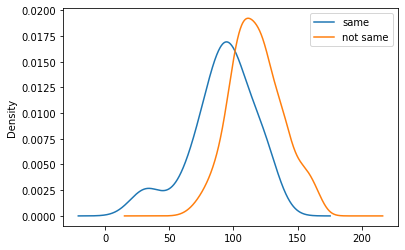

In [ ]:
df[df.decision == "Yes"].euclidean_distance.plot.kde(label='same')
df[df.decision == "No"].euclidean_distance.plot.kde(label='not same')
plt.legend()
plt.plot()